c:\Users\mitja\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\blocks.py:2184: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


                                                Date  Latitude  Longitude  \
date                                                                        
2023-02-15 19:35:00+00:00  2023-02-15 19:35:00+00:00  45.80208   15.18206   
2023-02-15 20:15:00+00:00  2023-02-15 20:15:00+00:00  45.80208   15.18206   
2023-02-15 20:35:00+00:00  2023-02-15 20:35:00+00:00  45.80208   15.18206   
2023-02-15 21:15:00+00:00  2023-02-15 21:15:00+00:00  45.80208   15.18206   
2023-02-15 21:35:00+00:00  2023-02-15 21:35:00+00:00  45.80208   15.18206   
...                                              ...       ...        ...   
2023-12-11 04:35:00+00:00  2023-12-11 04:35:00+00:00  45.80208   15.18206   
2023-12-11 05:35:00+00:00  2023-12-11 05:35:00+00:00  45.80208   15.18206   
2023-12-11 06:35:00+00:00  2023-12-11 06:35:00+00:00  45.80208   15.18206   
2023-12-11 07:35:00+00:00  2023-12-11 07:35:00+00:00  45.80208   15.18206   
2023-12-11 08:35:00+00:00  2023-12-11 08:35:00+00:00  45.80208   15.18206   

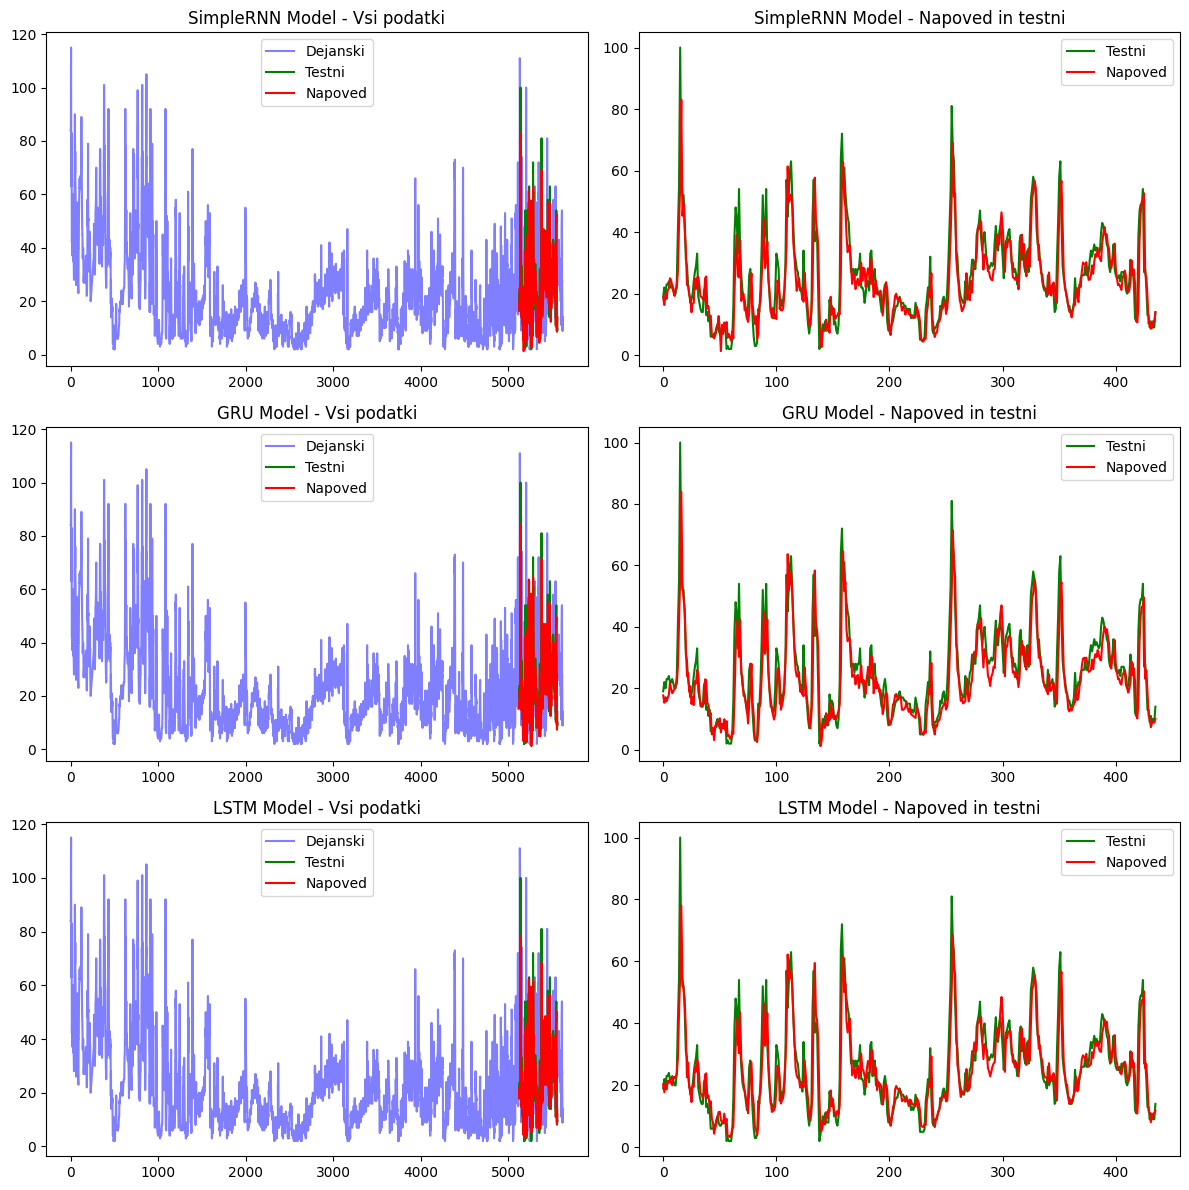

In [10]:
import pandas as pd
import numpy as np
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import joblib
import matplotlib.pyplot as plt

data = pd.read_csv('RV3_IIR_SIPIA.csv')

data['date'] = pd.to_datetime(data['Date'])
data.sort_values(by='date', inplace=True)
data.to_csv('neki.csv')
data.set_index('date', inplace=True)
print(data)
data_interpolated = data.interpolate(method='linear')
#data_interpolated = data.interpolate(method='mean')
print(data_interpolated.isna().sum())
data_interpolated = data_interpolated[['PM10']]

data_array = data_interpolated.values.astype(float)


scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_array)
train_size = len(data_scaled) - 500
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

joblib.dump(scaler, 'scaler_pm10.pkl')


def create_dataset(dataset, window_size):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i+window_size])
        y.append(dataset[i+window_size])
    return np.array(X), np.array(y)

window_size = 64
#window_size = 32
#window_size = 96
#window_size = 128 Vse slabše
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

X_train = X_train.reshape(-1, 1, window_size)
X_test = X_test.reshape(-1, 1, window_size)

def build_model(model_type):
    model = keras.Sequential()
    if model_type == 'SimpleRNN':
        #model.add(keras.layers.SimpleRNN(32, return_sequences=True, input_shape=(1, window_size)))
        #model.add(keras.layers.SimpleRNN(64, return_sequences=True, input_shape=(1, window_size)))
        #model.add(keras.layers.SimpleRNN(7, return_sequences=True, input_shape=(1, window_size))) Slabše
        model.add(keras.layers.SimpleRNN(16, return_sequences=True, input_shape=(1, window_size)))
        model.add(keras.layers.SimpleRNN(16))
    elif model_type == 'GRU':
        model.add(keras.layers.GRU(16, return_sequences=True, input_shape=(1, window_size)))
        model.add(keras.layers.GRU(16))
    elif model_type == 'LSTM':
        model.add(keras.layers.LSTM(16, return_sequences=True, input_shape=(1, window_size)))
        model.add(keras.layers.LSTM(16))
    
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(1))
    return model

models = {}
histories = {}
predictions = {}
for model_type in ['SimpleRNN', 'GRU', 'LSTM']:
    print(f"Training {model_type} model...")
    model = build_model(model_type)
    model.compile(optimizer='adam', loss='mse')
    #history = model.fit(X_train, y_train, epochs=25, verbose=2) Slabše
    history = model.fit(X_train, y_train, epochs=50, verbose=2)
    #history = model.fit(X_train, y_train, epochs=75, verbose=2) Slabše
    models[model_type] = model
    histories[model_type] = history
    predictions[model_type] = model.predict(X_test)

def inverse_transform(scaler, data):
    return scaler.inverse_transform(data.reshape(-1, 1))

num_models = len(models)
fig, axes = plt.subplots(num_models, 2, figsize=(12, num_models * 4))

for i, (model_type, model) in enumerate(models.items()):
    pred_original = inverse_transform(scaler, predictions[model_type])
    y_test_original = inverse_transform(scaler, y_test)
    full_data_original = inverse_transform(scaler, data_scaled)

    mse = mean_squared_error(y_test_original, pred_original)
    mae = mean_absolute_error(y_test_original, pred_original)
    evs = explained_variance_score(y_test_original, pred_original)
    axes[i, 0].plot(full_data_original, label='Dejanski', color='blue', alpha=0.5)
    axes[i, 0].plot(range(train_size, train_size + len(y_test_original)), y_test_original, label='Testni', color='green')
    axes[i, 0].plot(range(train_size, train_size + len(pred_original)), pred_original, label='Napoved', color='red')
    axes[i, 0].set_title(f'{model_type} Model - Vsi podatki')
    axes[i, 0].legend()

    axes[i, 1].plot(y_test_original, label='Testni', color='green')
    axes[i, 1].plot(pred_original, label='Napoved', color='red')
    axes[i, 1].set_title(f'{model_type} Model - Napoved in testni')
    axes[i, 1].legend()

    print(f"Model: {model_type}")
    print(f"MAE: {mae:.3f}, MSE: {mse:.3f}, EVS: {evs:.3f}\n")

plt.tight_layout()
plt.show()

